# Examining SAT Scores by Race, Income, and Gender in NYC Schools
by Nicholas Archambault

The SAT, or Scholastic Aptitude Test, is an exam that U.S. high school students take before applying to college. Colleges take the test scores into account when deciding who to admit, so it's fairly important to perform well on it.

The test consists of two sections, each of which has 800 possible points. The combined score is out of 1,600 possible points. For many years, the test consisted of three 800-point sections, for a total of 2,400 possible points.  SAT scores examined in this project are out of 2,400. Organizations often rank high schools by their average SAT scores. The scores are also considered a measure of overall school district quality.

One of the most controversial issues in the U.S. educational system is the efficacy of standardized tests like the SAT, and whether they're unfair to certain groups. This project examines the open-source data from New York City schools on school performance and student SAT score distribution to better understand the relationships between SAT scores, geography, and demographics, including race, income and gender.

Data for this project were amalgamated from:
   * `Data.gov` - A directory of government data downloads
   * `/r/datasets` - A subreddit with hundreds of available datasets
   * `Awesome datasets` - A Github-hosted collection of datasets
   * `rs.io` - A blog post collection of datasets
   
This project incorporates 6 datasets on demographics and school performance, as well as 2 surveys from students evaluating their schools.

   * `ap_2010.csv` - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
   * `class_size.csv` - Information on class size for each school
   * `demographics.csv` - Demographic information for each school
   * `graduation.csv` - The percentage of students who graduated, and other outcome information
   * `hs_directory.csv` - A directory of high schools in NYC
   * `sat_results.csv` - SAT scores for each high school in New York City
   * `survey_all.txt` - Survey of parents, teachers, and students at each school
   * `survey_d75.txt` - Survey of parents, teachers, and students at each District 75 school. These schools provide services to students with learning and physical disabilities and fall under the purview of NYC public schools
   

## Data Read-in and Initial Cleaning

We can start by importing the necessary packages and reading in all CSV files, storing each in a dictionary, `data`.

In [1]:
import pandas as pd
import numpy as np
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("{}".format(f))
    data[f.replace(".csv", "")] = d

Next, we'll read in the two surveys, concatenate them vertically, adjust column names, and limit extraneous parameterrs. Columns included feature parent, student, and teacher responses to questions about school safety, academic performance, and more.

In [2]:
all_survey = pd.read_csv("survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis = 0)

# The DBN, or 'district borough number', is the unique identifier of individual schools. 
# Convert column name to render it consistent with other data files
survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]

# Eliminate all other columns besides those specified
survey = survey.loc[:,survey_fields]

# Reassign in dictionary
data["survey"] = survey

## Construct Missing DBN Column

Some of the datasets, including `class_size` and `hs_directory`, are missing DBN numbers. For `hs_directory`, we can copy the appropriate column from its location within the dataset, while for `class_size`, we have the pieces to construct each school's DBN. Examining the data, we see that the full DBN for other datasets is simply a string concatenation of the `CSD` and `School Code` columns in `class_size`. The DBN is always padded, meaning we'll add a leading zero whenever `CSD` consists of a single digit.

In [3]:
# Replace DBN column in `hs_directory~
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

# Create function that pads CSD number
def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation

# Apply function and concatenate to construct DBN for `class_size`    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

Ensuring that we have DBN's of the same format, length and column name will be essential when we eventually combine all the datasets based on each unique school.

## Create Numeric Columns

Currently, a school's average SAT score is split between the test's three sections: reading, writing and math. To get a more concise and digestible picture of schools' performances relative to one another, we'll convert these section scores from strings to numeric values and sum them, creating a 'total average SAT score' column in the process.

We also need to extract latitude and longitude of each school from `hs_directory` for later geographic plotting. Surrounding each coordinate is extraneous information that can be filtered out with a regular expression isolating the coordinates themselves. These coordinates can then be converted to numbers as well.

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense Datasets

We'll next establish the `class_size` dataset as its own object, then condense it. Currently, the dataset contains over 27,000 rows for all grades and years. The following steps limit that dataset so that it only contains non-specialized high schools.

The dataset can be condensed further by grouping all entries by unique DBN.

We'll also limit the `demographics` data to include a single school year, 2011-2012, and `graduation` to include a single cohort of graduates and outcomes from 2006.

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace = True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP Scores to Numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine Data

With all the datasets properly cleaned and condensed, we can now merge them by DBN, imputing NaN values with column means.

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on = "DBN", how = "left")
combined = combined.merge(data["graduation"], on = "DBN", how = "left")
 
to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on = "DBN", how = "inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

## Add School District Column for Mapping

We'll need each school's district in order to map it geographically. Knowing that the first two digits of the DBN is the numerical code for school district, we can write a quick function to scrape these values and create a new column to hold them.

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find Correlations

Since we've imputed or filled all NaN values, we can find the correlations of each column with one another as the first step to examining the relationships between SAT performance and demographic characteristics.

In [21]:
correlations = combined.corr()
correlations = correlations["sat_score"]

def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')
    
print_full(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

Some columns yield nonsensical correlations since they are non-numeric, but we notice some interesting trends between others. Schools with higher numbers of AP test takers and better performance on those tests tend to perform well on the SAT. Surprisingly, total students and average class size both have moderately positive correlations with SAT performance, contradicting the assumption that smaller classes and a smaller student body would facilitate more individualized student-teacher interaction and better test performance.

The most striking results, though, pertain to demographic parameters. The number and percentage of schools' English language learner students both have negative correlation with SAT performance, as does the percentage of special education students. The percentages of Black and Hispanic students also correlates negatively with SAT performance (-0.284 and -0.396), while the percentages of Asian and white students correlate modestly to strongly positively (0.571 and 0.621), reinforcing racial stereotypes of school performance.

These results indicate that it may be useful to examine the relationship between demographics -- including race, income, and gender -- with SAT performance.

# Plotting Survey Correlations

Exploratory plots offer a helpful visual perspective on the correlation results.

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

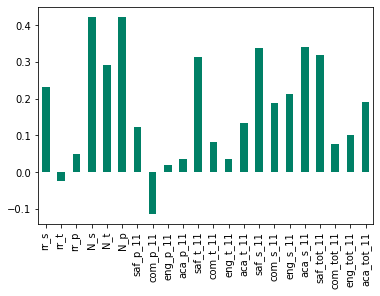

In [11]:
combined.corr()["sat_score"][survey_fields].plot.bar(cmap = "summer")

Let's look at student and parent responses to a survey question about school safety as a primer for the following examination of school safety by district.

Text(0, 0.5, 'School SAT Score')

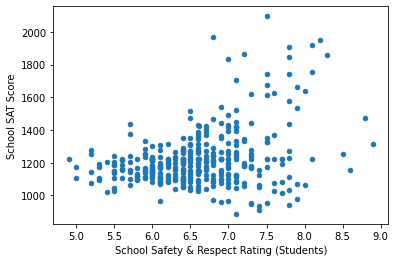

In [28]:
combined.plot.scatter("saf_s_11", "sat_score")
plt.xlabel("School Safety & Respect Rating (Students)")
plt.ylabel("School SAT Score")

Text(0, 0.5, 'School SAT Score')

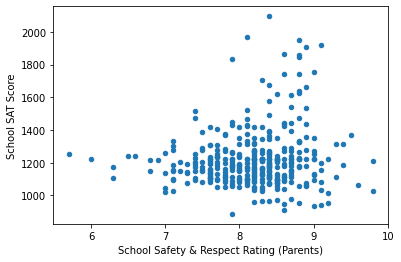

In [29]:
combined.plot.scatter("saf_p_11", "sat_score")
plt.xlabel("School Safety & Respect Rating (Parents)")
plt.ylabel("School SAT Score")

Based on the visuals, there seems to be a slight positive relationship between these metrics and SAT performance.

In [33]:
print("Students: {}".format(combined.corr()['saf_s_11']['sat_score']))
print("Parents: {}".format(combined.corr()['saf_p_11']['sat_score']))

Students: 0.3376387443608812
Parents: 0.12291283627180771


Indeed, the correlations bear out the previous observation.  We note, though, that the correlation between parent and student responses with SAT performance are substantially different.

# Plotting Safety by District

It might be worthy to check out how school safety varies geographically -- it's likely that schools in different neighborhoods of New York receive different levels of funding and are attended by different subsects of the greater population, thereby leading to disparities in students' perception of their safety. Let's see if any of those assumptions come to light.

We'll aggregate schools by district to realize an average longitude, latitude, and safety rating.  Then, we can use the 'basemap' package to plot a rough map plot of New York and superimpose the longitude and latitude of different school districts.

In [34]:
districts = combined.groupby("school_dist").agg(np.mean)
districts.reset_index(inplace = True)

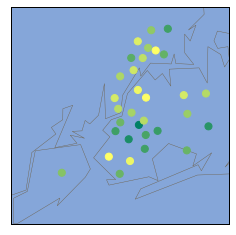

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()

m.scatter(longitudes, latitudes, s = 50, zorder = 2, latlon = True, c = districts["saf_s_11"], cmap = "summer")
plt.show()

The above plot shows the average safety score of various school districts. Paler dots represent lower safety ratings, while darker green dots correspond to safer school districts.

We find that most darker dots are clustered in the Manhattan and Brooklyn areas, while many of the paler dots fall in or near the Bronx. These results corroborate assumptions that schools in higher-income locations -- with, perhaps, wealthier or more homogenous student bodies -- are perceived as safer -- and may, in fact, be objectively safer.

# Plotting Race and SAT Performance

Next, we'll look into the relationship between race and SAT performance, given that we previously observed some interesting disparities in correlations.

[Text(0, 0, '% White'),
 Text(0, 0, '% Asian'),
 Text(0, 0, '% Black'),
 Text(0, 0, '% Hispanic')]

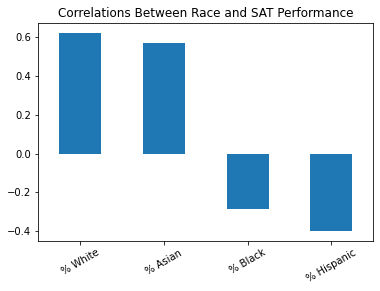

In [45]:
races = ["white_per", "asian_per", "black_per", "hispanic_per"]
ax = combined.corr()["sat_score"][races].plot.bar(rot = 30, title = "Correlations Between Race and SAT Performance")
ax.set_xticklabels(["% White", "% Asian", "% Black", "% Hispanic"])

The above plot immediately corroborates our previous finding that higher percentages of white and Asian students positively correlate with better SAT performance, while the converse is true for Black and Hispanic students.

Let's examine Hispanic student performance in a bit more depth.

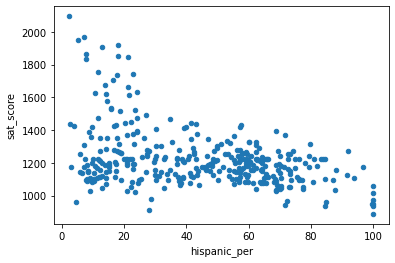

In [48]:
combined.plot.scatter(x = "hispanic_per", y = "sat_score")

We may find it more useful to examine schools with unusually high and low Hispanic representation. 

In [47]:
# Examine schools where over 95% of students identify as Hispanic
hispanic = combined[combined["hispanic_per"] > 95]
hispanic

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
44,02M542,MANHATTAN BRIDGES HIGH SCHOOL,66,336.0,378.0,344.0,1058.0,Manhattan Bridges High School,67.000000,102.000000,...,0,0,0,0.0,0.0,0.0,"525 West 50Th Street\nNew York, NY 10019\n(40....",40.765027,-73.992517,02
82,06M348,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,70,380.0,395.0,399.0,1174.0,0,129.028846,197.038462,...,Then to New York City residents,0,0,0.0,0.0,0.0,"511 West 182Nd Street\nNew York, NY 10033\n(40...",40.848879,-73.930807,06
89,06M552,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,56,339.0,349.0,326.0,1014.0,GREGORIO LUPERON HS SCI & MATH,88.000000,138.000000,...,0,0,0,0.0,0.0,0.0,"501 West 165Th\nNew York, NY 10032\n(40.838032...",40.838032,-73.938371,06
125,09X365,ACADEMY FOR LANGUAGE AND TECHNOLOGY,54,315.0,339.0,297.0,951.0,Academy for Language and Technology,20.000000,20.000000,...,0,0,0,0.0,0.0,0.0,"1700 Macombs Road\nBronx, NY 10453\n(40.849102...",40.849102,-73.916088,09
141,10X342,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,49,300.0,333.0,301.0,934.0,International School for Liberal Arts,55.000000,73.000000,...,0,0,0,0.0,0.0,0.0,"2780 Reservoir Avenue\nBronx, NY 10468\n(40.87...",40.870377,-73.898163,10
176,12X388,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,30,321.0,351.0,298.0,970.0,0,129.028846,197.038462,...,0,0,0,0.0,0.0,0.0,"1300 Boynton Avenue\nBronx, NY 10472\n(40.8313...",40.831366,-73.878823,12
253,19K583,MULTICULTURAL HIGH SCHOOL,29,279.0,322.0,286.0,887.0,Multicultural High School,44.000000,44.000000,...,0,0,0,0.0,0.0,0.0,"999 Jamaica Avenue\nBrooklyn, NY 11208\n(40.69...",40.691144,-73.868426,19
286,24Q296,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,55,317.0,323.0,311.0,951.0,0,129.028846,197.038462,...,0,0,0,0.0,0.0,0.0,"45-10 94Th Street\nElmhurst, NY 11373\n(40.743...",40.743303,-73.870575,24


Of schools with this high a Hispanic population, we note that most are specialized: some are scientific schools, others international or expeditionary. The total number of SAT and AP test takers does not exceed 100 at any of these schools, and the average SAT score among them appears relatively low, around 1000 out of 2400.

We can compare these results with schools with lower percentages of Hispanic students and higher SAT scores.

In [50]:
high_hisp = combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]
high_hisp

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
37,02M475,STUYVESANT HIGH SCHOOL,832,679.0,735.0,682.0,2096.0,STUYVESANT HS,1510.0,2819.0,...,0,0,0,0.0,0.0,0.0,"345 Chambers Street\nNew York, NY 10282\n(40.7...",40.717746,-74.014049,02
151,10X445,BRONX HIGH SCHOOL OF SCIENCE,731,632.0,688.0,649.0,1969.0,BRONX HS OF SCIENCE,1190.0,2435.0,...,0,0,0,0.0,0.0,0.0,"75 West 205 Street\nBronx, NY 10468\n(40.87705...",40.877056,-73.889780,10
187,13K430,BROOKLYN TECHNICAL HIGH SCHOOL,1277,587.0,659.0,587.0,1833.0,BROOKLYN TECHNICAL HS,2117.0,3692.0,...,0,0,0,0.0,0.0,0.0,"29 Ft Greene Place\nBrooklyn, NY 11217\n(40.68...",40.688107,-73.976745,13
327,28Q687,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,121,612.0,660.0,596.0,1868.0,Queens HS for Science York Colllege,215.0,338.0,...,0,0,0,0.0,0.0,0.0,"94-50 159 Street\nJamaica, NY 11433\n(40.70099...",40.700999,-73.798154,28
356,31R605,STATEN ISLAND TECHNICAL HIGH SCHOOL,227,635.0,682.0,636.0,1953.0,STATEN ISLAND TECHNICAL HS,528.0,905.0,...,0,0,0,0.0,0.0,0.0,"485 Clawson Street\nStaten Island, NY 10306\n(...",40.567913,-74.115362,31


It is evident that the schools on this list are high-performing, based on their numbers of test-taking students and the high average SAT scores. It is notable that all five of the schools on this list are specialized technical or scientific high schools, which likely screen for students based on academic performance. 

Both of these results seem to corroborate the negative correlation between Hispanic student population and SAT performance that we previously observed. 